In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm


In [2]:
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")

PyTorch Version: 2.4.1+cu121
CUDA Device: NVIDIA GeForce RTX 2060
CUDA Compute Capability: 7.5
Total Memory: 5.61 GB


### MNIST Dataset

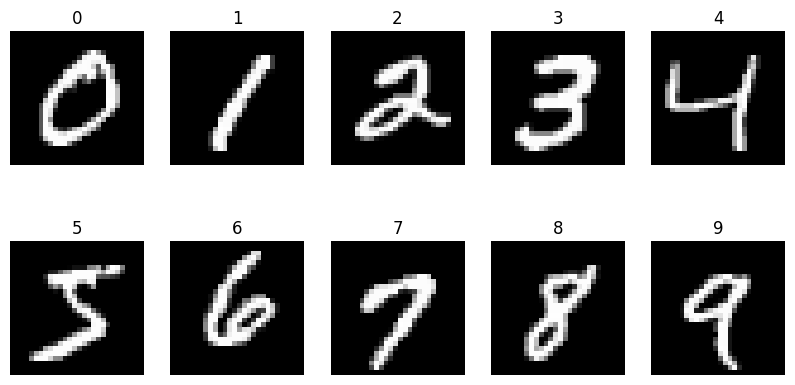

In [3]:
# load MNIST dataset from utils
from utils import get_dataset

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(
        train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap="gray"
    )
    ax.set_title(f"{i}")
    ax.axis("off")

In [4]:
from utils import get_network

ConvNet3 = get_network('ConvNet', channel, num_classes, im_size)
print(ConvNet3)

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)


In [5]:
n_epochs = 2
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)

for epoch in range(n_epochs):
    ConvNet3.train()
    running_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_MNIST_dataloader, 0),
        total=len(train_MNIST_dataloader),
        desc=f"Epoch {epoch+1}",
    )

    total_iterations = len(train_MNIST_dataloader)
    for i, data in enumerate(train_MNIST_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = ConvNet3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        percentage_complete = (i + 1) / total_iterations * 100
        progress_bar.set_postfix(loss=running_loss / (i + 1))
        progress_bar.update(1)



Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

In [6]:
# report classification accuracy for test dataset
ConvNet3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in test_MNIST_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = ConvNet3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

## Dataset Distillation using Attention matching Algorithm

In [6]:
""" Attention Matching Algorithm hyperparameters """
imgs_per_class = 10
minibatch_size = 256

In [7]:
# learn synthetic dataset using Attention matching algorithm

""" organize the real dataset """
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [
    torch.unsqueeze(train_MNIST_dataset[i][0], dim=0)
    for i in range(len(train_MNIST_dataset))
]
labels_all = [train_MNIST_dataset[i][1] for i in range(len(train_MNIST_dataset))]

for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device)

for c in range(num_classes):
    print("class %d: %d real images" % (c, len(indices_class[c])))


def get_images(c, n):  # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


for ch in range(channel):
    print(
        "real images channel %d, mean = %.4f, std = %.4f"
        % (ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch]))
    )

class 0: 5923 real images
class 1: 6742 real images
class 2: 5958 real images
class 3: 6131 real images
class 4: 5842 real images
class 5: 5421 real images
class 6: 5918 real images
class 7: 6265 real images
class 8: 5851 real images
class 9: 5949 real images
real images channel 0, mean = -0.0001, std = 1.0000


In [8]:
""" Initialize the synthetic dataset """
images_syn = torch.randn(
    size=(num_classes*imgs_per_class, channel, im_size[0], im_size[1]),
    dtype=torch.float,
    requires_grad=True,
    device=device,
)
labels_syn = torch.tensor(
    [np.ones(imgs_per_class) * c for c in range(num_classes)],
    dtype=torch.long,
    requires_grad=False,
    device=device,
)

# Initialize synthetic dataset using real images
for c in range(num_classes):
    real_images = get_images(c, imgs_per_class)
    images_syn.data[c*imgs_per_class:(c+1)*imgs_per_class] = real_images.data

# print details of synthetic dataset, size and all
print(images_syn.size())
print(labels_syn.size())

torch.Size([100, 1, 28, 28])
torch.Size([10, 10])


/tmp/ipykernel_142754/3391903044.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels_syn = torch.tensor(


In [9]:
activations = {}
def getActivation(name):
    def hook_func(m, inp, op):
        activations[name] = op.clone()
    return hook_func

''' Defining the Refresh Function to store Activations and reset Collection '''
def refreshActivations(activations):
    model_set_activations = [] # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations

''' Defining the Delete Hook Function to collect Remove Hooks '''
def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return
        
def attach_hooks(net):
    hooks = []
    base = net.module if torch.cuda.device_count() > 1 else net
    for module in (base.features.named_modules()):
        if isinstance(module[1], nn.ReLU):
            # Hook the Ouptus of a ReLU Layer
            hooks.append(base.features[int(module[0])].register_forward_hook(getActivation('ReLU_'+str(len(hooks)))))
    return hooks

In [10]:
""" Train the synthetic dataset using Attention Matching Algorithm """

optimizer_img = torch.optim.SGD([images_syn], lr=0.1, momentum=0.9)
optimizer_img.zero_grad()

loss = torch.tensor(0.0, device=device)

images_real_all = []
images_syn_all = []

for c in range(num_classes):
    img_real = get_images(c, minibatch_size)
    img_sync = images_syn[c * imgs_per_class : (c + 1) * imgs_per_class].reshape(
        (imgs_per_class, channel, im_size[0], im_size[1])
    )

    images_real_all.append(img_real)
    images_syn_all.append(img_sync)

images_real_all = torch.cat(images_real_all, dim=0)
images_syn_all = torch.cat(images_syn_all, dim=0)

hooks = attach_hooks(ConvNet3)
output_real = ConvNet3(images_real_all).detach()
activations, original_model_set_activations = refreshActivations(activations)


output_syn = ConvNet3(images_syn_all).detach()
activations, synthetic_model_set_activations = refreshActivations(activations)
delete_hooks(hooks)

print("output_real", output_real.size())
print("output_syn", output_syn.size())


OutOfMemoryError: CUDA out of memory. Tried to allocate 320.00 MiB. GPU 0 has a total capacity of 5.61 GiB of which 253.81 MiB is free. Including non-PyTorch memory, this process has 5.16 GiB memory in use. Of the allocated memory 4.90 GiB is allocated by PyTorch, and 151.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### MHIST Dataset

In [ ]:
# load MHIST dataset from MHISTDataset class
import MHISTDataset

train_MHIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/train', transform=None)
test_MNIST_dataset = MHISTDataset.MHISTDataset('../mhist_dataset/images-split/test', transform=None)

# find train_MHIST_dataset with "HP" label, train_MHHIST_dataset[i][2]
HP_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'HP']
SSA_indices = [i for i in range(len(train_MHIST_dataset)) if train_MHIST_dataset[i][2] == 'SSA']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(train_MHIST_dataset[HP_indices[0]][0])
axes[0].set_title("HP")
axes[0].axis('off')
axes[1].imshow(train_MHIST_dataset[SSA_indices[0]][0])
axes[1].set_title("SSA")
axes[1].axis('off')
plt.show()

### ConvNet3 Model